In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
from torch.utils.data import DataLoader

%matplotlib inline

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [3]:
def random_zero(array, pct=0.5):
    """array: массив np.array
       pct: % массива, подлежащего замене на ноль
       
    """    
    # генерация индексов всего массива
    ind = range(783)
    # размер массива, подлежащего замене на ноль
    size = int(len(ind) * pct)
    
    # случайная генерация индексов размера size без возвращения
    random_ind = np.random.choice(ind, size=size - 1, replace=False)
    
    # замена значений случайных индексов в массиве array на ноль
    array[random_ind] = 0
    
    return array

def reshape_func(data):
    for i, row in enumerate(data):
        reshape_row = row.reshape(-1, 1)
        rand_zero_row = random_zero(reshape_row)
        data[i] = rand_zero_row.reshape(1, 28, 28)  

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

In [5]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
       # dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = min(- torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho))
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [6]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data0 = data
        reshape_func(data0)
        dataX = (data0 + torch.randn(data.size())).clamp(0,1)
        for model in models.values():
            model.optim.zero_grad()
            output = model(dataX)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data0 = data
            reshape_func(data0)
            dataX = (data0 + torch.randn(data.size())).clamp(0,1)
            output = {k: m(dataX) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [9]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.496981 32: 0.496447 64: 0.489725
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.416863 32: 0.414764 64: 0.414676
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.456881 32: 0.456685 64: 0.456679
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.433441 32: 0.433438 64: 0.433375
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.397036 32: 0.397162 64: 0.396937
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.453949 32: 0.454639 64: 0.453410
Test set:
16: loss: 0.4272	rho_loss: 0.0002
32: loss: 0.4279	rho_loss: 0.0001
64: loss: 0.4271	rho_loss: 0.0001

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.465983 32: 0.466869 64: 0.465667
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.420791 32: 0.422375 64: 0.419238
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.443527 32: 0.447321 64: 0.439433
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.435973 32: 0.440654 64: 0.433363
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.393436 32: 0.394837 64: 0.393474
Train

Test set:
16: loss: 0.3568	rho_loss: 0.0002
32: loss: 0.3530	rho_loss: 0.0001
64: loss: 0.3503	rho_loss: 0.0001

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.340758 32: 0.337789 64: 0.334258
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.352771 32: 0.348847 64: 0.344994
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.352149 32: 0.347711 64: 0.344332
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.351543 32: 0.349500 64: 0.345399
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.366860 32: 0.362291 64: 0.360699
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.370193 32: 0.365857 64: 0.363017
Test set:
16: loss: 0.3549	rho_loss: 0.0002
32: loss: 0.3512	rho_loss: 0.0001
64: loss: 0.3484	rho_loss: 0.0001

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.356304 32: 0.353606 64: 0.349717
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.369246 32: 0.367942 64: 0.364009
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.332816 32: 0.330123 64: 0.327490
Train Epoch: 16 [30000/50000 (60%)]	Losses 16

Train Epoch: 28 [40000/50000 (80%)]	Losses 16: 0.364796 32: 0.360130 64: 0.355959
Train Epoch: 28 [50000/50000 (100%)]	Losses 16: 0.321197 32: 0.315641 64: 0.311145
Test set:
16: loss: 0.3448	rho_loss: 0.0002
32: loss: 0.3403	rho_loss: 0.0001
64: loss: 0.3357	rho_loss: 0.0001

Train Epoch: 29 [0/50000 (0%)]	Losses 16: 0.315163 32: 0.310956 64: 0.307159
Train Epoch: 29 [10000/50000 (20%)]	Losses 16: 0.358855 32: 0.354957 64: 0.350140
Train Epoch: 29 [20000/50000 (40%)]	Losses 16: 0.345185 32: 0.340466 64: 0.335322
Train Epoch: 29 [30000/50000 (60%)]	Losses 16: 0.326093 32: 0.321174 64: 0.317202
Train Epoch: 29 [40000/50000 (80%)]	Losses 16: 0.357796 32: 0.352638 64: 0.348731
Train Epoch: 29 [50000/50000 (100%)]	Losses 16: 0.350155 32: 0.345079 64: 0.339286
Test set:
16: loss: 0.3444	rho_loss: 0.0002
32: loss: 0.3397	rho_loss: 0.0001
64: loss: 0.3351	rho_loss: 0.0001

Train Epoch: 30 [0/50000 (0%)]	Losses 16: 0.333557 32: 0.328744 64: 0.324583
Train Epoch: 30 [10000/50000 (20%)]	Losses 1

In [10]:
data, _ = next(iter(test_loader))
output = models['64'](data + torch.randn(data.size()).clamp(-1,1))
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([38, 35, 40, 38, 40, 37, 42, 43, 38, 36, 31, 40, 39, 38, 40, 40, 39, 38,
        37, 36, 36, 37, 40, 37, 41, 42, 40, 40, 39, 40, 42, 38, 36, 39, 36, 37,
        42, 42, 39, 43, 43, 40, 41, 49, 36, 37, 40, 40, 42, 39])


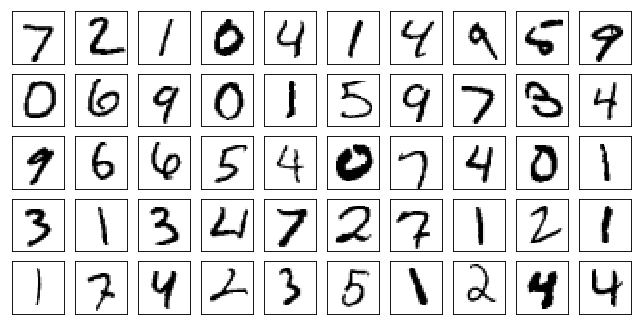

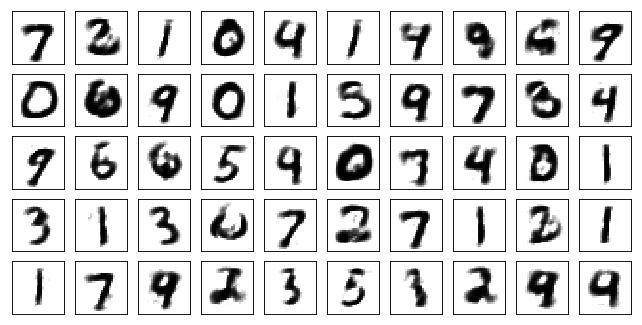

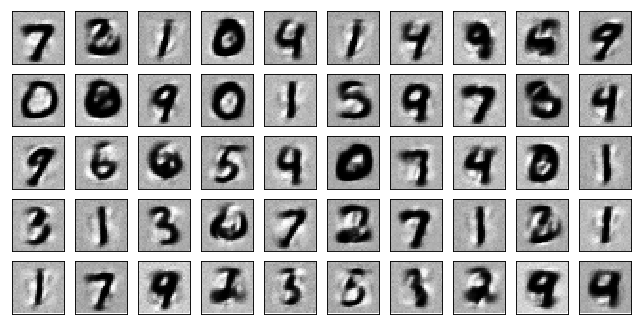

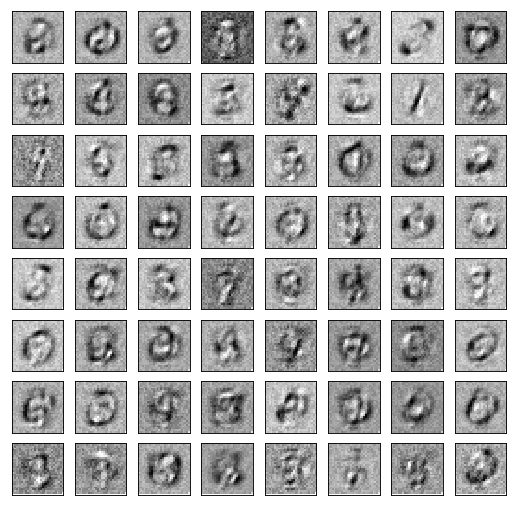

In [11]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))